In [4]:
pip install pandas numpy matplotlib seaborn scipy plotly missingno


Note: you may need to restart the kernel to use updated packages.


In [1]:
# === Step 1: Setup ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")
sns.set(font_scale=1.1)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 160)

print("Environment ready ✔")


Environment ready ✔


In [3]:
import os
os.getcwd()


'C:\\Users\\mihir'

In [6]:
import pandas as pd

df = pd.read_csv("sensor_maintenance_data.csv")
df.columns


Index(['Sensor_ID', 'Timestamp', 'Voltage (V)', 'Current (A)', 'Temperature (°C)', 'Power (W)', 'Humidity (%)', 'Vibration (m/s²)', 'Equipment_ID',
       'Operational Status', 'Fault Status', 'Failure Type', 'Last Maintenance Date', 'Maintenance Type', 'Failure History', 'Repair Time (hrs)',
       'Maintenance Costs (USD)', 'Ambient Temperature (°C)', 'Ambient Humidity (%)', 'External Factors', 'X', 'Y', 'Z', 'Equipment Relationship',
       'Equipment Criticality', 'Fault Detected', 'Predictive Maintenance Trigger'],
      dtype='object')

In [7]:
ahu_df = pd.read_csv("combined_SDAHU.csv")
ahu_df.columns


Index(['Datetime', 'CHWC_VLV', 'CHWC_VLV_DM', 'MA_TEMP', 'OA_CFM', 'OA_DMPR', 'OA_DMPR_DM', 'OA_TEMP', 'RA_CFM', 'RA_DMPR', 'RA_DMPR_DM', 'RA_TEMP', 'RF_CS',
       'RF_SPD', 'RF_SPD_DM', 'RF_WAT', 'SA_CFM', 'SA_SP', 'SA_SPSPT', 'SA_TEMP', 'SA_TEMPSPT', 'SF_CS', 'SF_SPD', 'SF_SPD_DM', 'SF_WAT', 'SYS_CTL',
       'ZONE_TEMP_1', 'ZONE_TEMP_2', 'ZONE_TEMP_3', 'ZONE_TEMP_4', 'ZONE_TEMP_5', 'system_type', 'source_file', 'scenario'],
      dtype='object')

In [8]:
# Corrected CSV loading with correct datetime columns

sens = pd.read_csv("sensor_maintenance_data.csv", parse_dates=["Timestamp"])
ahu  = pd.read_csv("combined_SDAHU.csv", parse_dates=["Datetime"])

print("Sensor Data:", sens.shape)
print("AHU Data:", ahu.shape)

sens.head()


Sensor Data: (500, 27)
AHU Data: (10818901, 34)


,Sensor_ID,Timestamp,Voltage (V),Current (A),Temperature (°C),Power (W),Humidity (%),Vibration (m/s²),Equipment_ID,Operational Status,Fault Status,Failure Type,Last Maintenance Date,Maintenance Type,Failure History,Repair Time (hrs),Maintenance Costs (USD),Ambient Temperature (°C),Ambient Humidity (%),External Factors,X,Y,Z,Equipment Relationship,Equipment Criticality,Fault Detected,Predictive Maintenance Trigger
0,S_1,2024-01-01 00:00:00,110,0.5,20,55.0,40,0.20,E_1,Operational,Fault Detected,Overload,2024-12-01,Preventive,Fault Detected,5,150,20,40,Clear Weather,0,0,0,Independent,High,1,1
1,S_2,2024-01-01 01:00:00,111,0.6,21,66.6,41,0.25,E_2,Under Maintenance,No Fault,NaN,2024-12-01,Corrective,No Fault,0,160,21,41,Storm,1,1,1,Dependent,Medium,0,0
2,S_3,2024-01-01 02:00:00,112,0.7,22,78.4,42,0.30,E_3,Operational,No Fault,NaN,2024-12-01,Preventive,No Fault,0,170,22,42,Clear Weather,2,2,2,Dependent,High,0,0
3,S_4,2024-01-01 03:00:00,113,0.8,23,90.4,43,0.35,E_4,Under Maintenance,Fault Detected,NaN,2024-12-01,Corrective,No Fault,8,180,23,43,Storm,3,3,3,Independent,Medium,1,0
4,S_5,2024-01-01 04:00:00,114,0.9,24,102.6,44,0.40,E_5,Operational,No Fault,Overload,2024-12-01,Preventive,No Fault,0,190,24,44,Clear Weather,4,4,4,Dependent,High,0,1


In [9]:
sens = sens.rename(columns={"Timestamp": "timestamp", "Equipment_ID": "asset_id"})
ahu  = ahu.rename(columns={"Datetime": "timestamp"})

sens.head(2), ahu.head(2)


(  Sensor_ID           timestamp  Voltage (V)  Current (A)  Temperature (°C)  Power (W)  Humidity (%)  Vibration (m/s²) asset_id Operational Status  \
 0       S_1 2024-01-01 00:00:00          110          0.5                20       55.0            40              0.20      E_1        Operational   
 1       S_2 2024-01-01 01:00:00          111          0.6                21       66.6            41              0.25      E_2  Under Maintenance   
 
      Fault Status Failure Type Last Maintenance Date Maintenance Type Failure History  Repair Time (hrs)  Maintenance Costs (USD)  Ambient Temperature (°C)  \
 0  Fault Detected     Overload            2024-12-01       Preventive  Fault Detected                  5                      150                        20   
 1        No Fault          NaN            2024-12-01       Corrective        No Fault                  0                      160                        21   
 
    Ambient Humidity (%) External Factors  X  Y  Z Equipment Re

In [11]:
# Create failure_flag column: 1 = failure event, 0 = normal
sens["failure_flag"] = sens["Fault Detected"].apply(
    lambda x: 1 if str(x).strip().lower() in ["yes", "true", "1"] else 0
)

sens["failure_flag"].value_counts()


failure_flag
0    333
1    167
Name: count, dtype: int64

In [12]:
print("=== Missing Value % ===")
missing = sens.isna().mean().sort_values(ascending=False) * 100
missing[missing > 0]

missing_ahu = ahu.isna().mean().sort_values(ascending=False) * 100
missing_ahu[missing_ahu > 0]


=== Missing Value % ===


Series([], dtype: float64)

In [13]:
sens.describe().T.head(15)


,count,mean,min,25%,50%,75%,max,std
timestamp,500,2024-01-11 09:30:00,2024-01-01 00:00:00,2024-01-06 04:45:00,2024-01-11 09:30:00,2024-01-16 14:15:00,2024-01-21 19:00:00,NaN
Voltage (V),500.0,114.5,110.0,112.0,114.5,117.0,119.0,2.875158
Current (A),500.0,0.7,0.5,0.6,0.7,0.8,0.9,0.141563
Temperature (°C),500.0,24.5,20.0,22.0,24.5,27.0,29.0,2.875158
Power (W),500.0,80.35,55.0,66.6,80.15,94.4,107.1,17.293311
Humidity (%),500.0,44.5,40.0,42.0,44.5,47.0,49.0,2.875158
Vibration (m/s²),500.0,0.3,0.2,0.25,0.3,0.35,0.4,0.070781
Repair Time (hrs),500.0,2.336,0.0,0.0,0.0,6.0,9.0,3.402095
Maintenance Costs (USD),500.0,195.0,150.0,170.0,195.0,220.0,240.0,28.751579
Ambient Temperature (°C),500.0,22.0,20.0,21.0,22.0,23.0,24.0,1.41563


In [14]:
ahu.describe().T.head(15)


,count,mean,min,25%,50%,75%,max,std
timestamp,10818901,2018-07-02 22:24:08.131802368,2018-01-01 01:00:00,2018-04-04 18:27:00,2018-07-03 05:04:00,2018-09-30 15:40:00,2018-12-31 23:59:00,NaN
CHWC_VLV,10818901.0,0.270361,-0.000001,0.0,0.1,0.584033,1.000001,0.292667
CHWC_VLV_DM,10818901.0,0.240585,0.0,0.0,0.0,0.592669,1.0,0.341651
MA_TEMP,10818901.0,65.140697,11.888319,56.028748,68.877426,70.2511,110.457214,8.718321
OA_CFM,10818901.0,357730.44,357730.44,357730.44,357730.44,357730.44,357730.44,0.0
OA_DMPR,10818901.0,0.239758,0.0,0.0,0.1,0.25,1.0,0.327512
OA_DMPR_DM,10818901.0,0.189702,0.0,0.0,0.1,0.1,1.0,0.30796
OA_TEMP,10818901.0,50.359981,-9.039978,34.268017,51.98001,67.75401,95.0,20.896085
RA_CFM,10818901.0,318662.535558,-285691.06,-0.000001,409198.2,596170.9,1275262.8,306946.716017
RA_DMPR,10818901.0,0.760149,-0.0,0.75,0.9,1.0,1.0,0.327455


In [15]:
print("Sensor Data Time Range:", sens["timestamp"].min(), "→", sens["timestamp"].max())
print("AHU Data Time Range   :", ahu["timestamp"].min(), "→", ahu["timestamp"].max())


Sensor Data Time Range: 2024-01-01 00:00:00 → 2024-01-21 19:00:00
AHU Data Time Range   : 2018-01-01 01:00:00 → 2018-12-31 23:59:00


In [16]:
sens["asset_id"].value_counts().head()


asset_id
E_1    10
E_2    10
E_3    10
E_4    10
E_5    10
Name: count, dtype: int64

In [17]:
sensor_cols = [
    col for col in sens.columns
    if col not in ["timestamp", "asset_id", "failure_flag", "Fault Status", "Fault Detected",
                   "Failure Type", "Operational Status"]
       and sens[col].dtype != "O"
]

sensor_cols[:10]


['Voltage (V)',
 'Current (A)',
 'Temperature (°C)',
 'Power (W)',
 'Humidity (%)',
 'Vibration (m/s²)',
 'Repair Time (hrs)',
 'Maintenance Costs (USD)',
 'Ambient Temperature (°C)',
 'Ambient Humidity (%)']

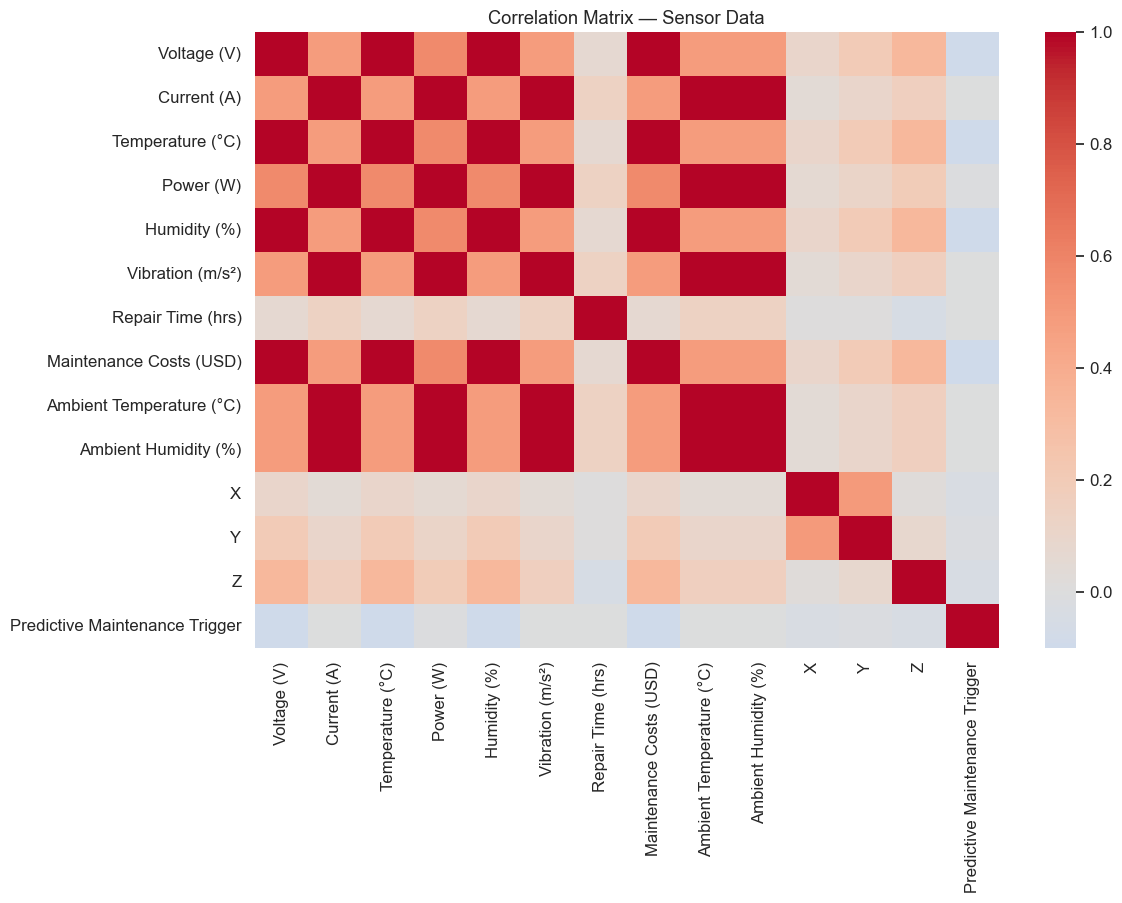

In [18]:
plt.figure(figsize=(12, 8))
sns.heatmap(sens[sensor_cols].corr(), cmap="coolwarm", center=0)
plt.title("Correlation Matrix — Sensor Data")
plt.show()


Numeric Sensor Columns Being Plotted: ['Voltage (V)', 'Current (A)', 'Temperature (°C)', 'Power (W)', 'Humidity (%)']


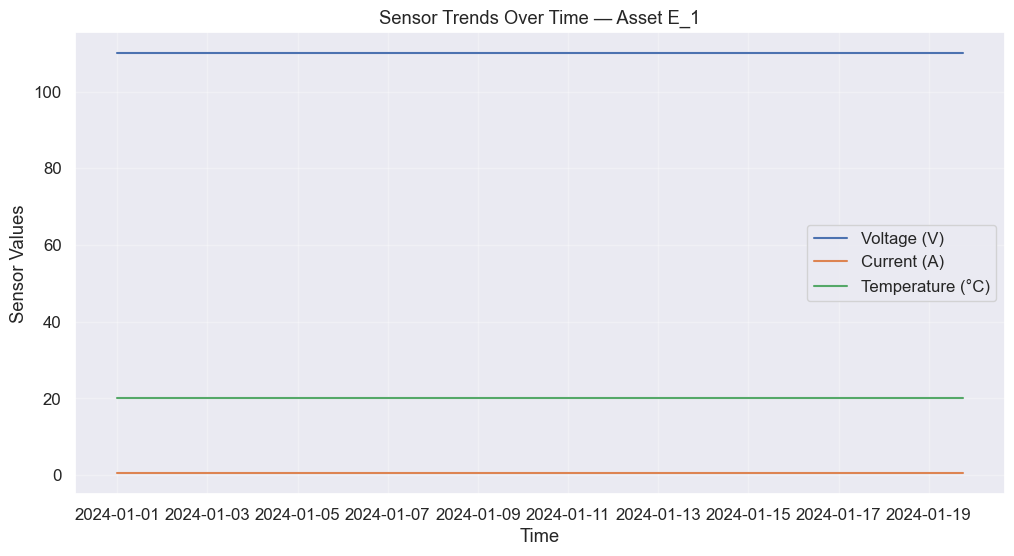

In [25]:
# Filter only numeric sensor columns (removes X, Y, Z, categorical, etc.)
numeric_sensor_cols = sens.select_dtypes(include=[np.number]).columns.tolist()

# Remove ID + failure flag + useless numeric fields
remove_cols = ["asset_id", "failure_flag"]
numeric_sensor_cols = [c for c in numeric_sensor_cols if c not in remove_cols]

print("Numeric Sensor Columns Being Plotted:", numeric_sensor_cols[:5])

# Choose an example asset
example_asset = sens["asset_id"].value_counts().index[0]
df_plot = sens[sens["asset_id"] == example_asset].sort_values("timestamp")

plt.figure(figsize=(12,6))

# Plot only numeric columns (this prevents crashes)
for col in numeric_sensor_cols[:3]:
    plt.plot(df_plot["timestamp"], df_plot[col], label=col)

plt.title(f"Sensor Trends Over Time — Asset {example_asset}")
plt.xlabel("Time")
plt.ylabel("Sensor Values")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


AHU Numeric Columns: ['CHWC_VLV', 'CHWC_VLV_DM', 'MA_TEMP', 'OA_CFM', 'OA_DMPR']


C:\Users\mihir\AppData\Local\Temp\ipykernel_30828\2021888075.py:17: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


C:\Users\mihir\AppData\Local\Temp\ipykernel_30828\2021888075.py:17: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


C:\Users\mihir\AppData\Local\Temp\ipykernel_30828\2021888075.py:17: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




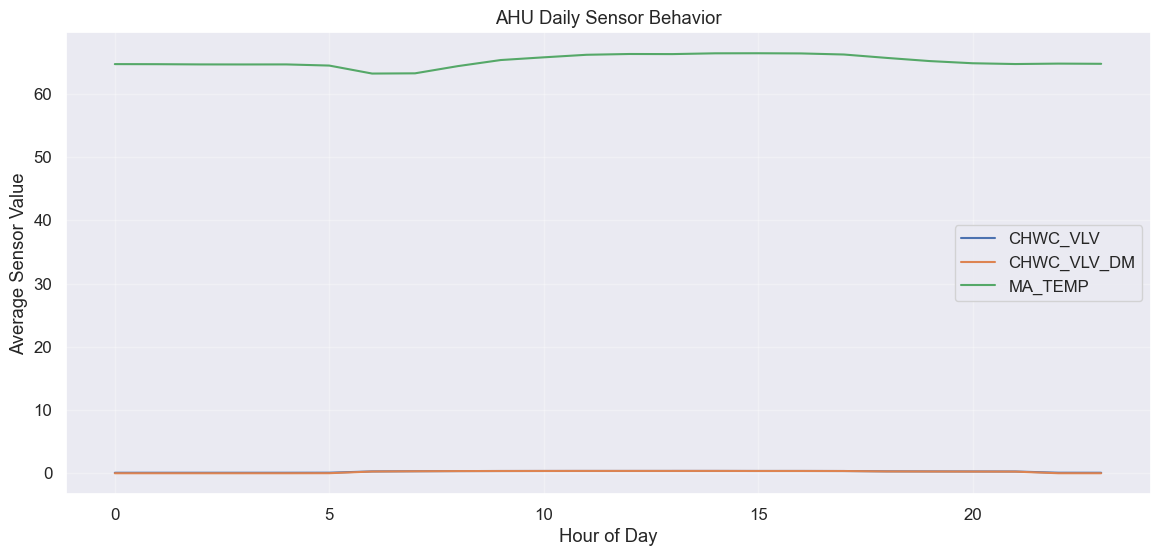

In [26]:
# Convert numeric columns only
ahu_numeric_cols = ahu.select_dtypes(include=[np.number]).columns.tolist()

# Remove metadata columns
remove_cols = ["hour"]
ahu_numeric_cols = [c for c in ahu_numeric_cols if c not in remove_cols]

print("AHU Numeric Columns:", ahu_numeric_cols[:5])

# Add hour column
ahu["hour"] = ahu["timestamp"].dt.hour

plt.figure(figsize=(14,6))

# Plot only numeric AHU sensor columns
for col in ahu_numeric_cols[:3]:
    sns.lineplot(data=ahu, x="hour", y=col, estimator="mean", ci=None, label=col)

plt.title("AHU Daily Sensor Behavior")
plt.xlabel("Hour of Day")
plt.ylabel("Average Sensor Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
